# GTEx RNA-seq data processing for eQTLs : Exploratory analysis

This notebook outlines how the expression matrices are handled prior to the eQTL mapping, and also include some exploratory analysis on the data. In particular, we focus on hidden structures within the expression data, and how we correct for the relevant covariates, both known and inferred.

## Also, you may find the the files under this directory very handy:

### <code>https://github.com/bee-hive/RNAseq_pipeline/tree/master/Data/Resources/gtex</code>

## SRA Runtable

The SRA Runtable is a data release that includes relevant information about all the experimental samples. Let's take a look at a few important details.


In [1]:
%%bash
# This part will depend on where the code is being run - the following code uses relative addresses
export proj='/Users/brian_jo/Desktop/Project/RNAseq_pipeline'

In [4]:
import os
import numpy as np
import pandas as pd

proj = os.environ['proj']

sra_runtable_phase1 = pd.read_csv(proj + '/Data/Resources/gtex/covariates/SRARunTable.txt', sep='\t')

- Assay_Type_s tells us whether it is a RNA-seq experiment or Whole-Exome Sequencing (WXS). We will only concern ourselves with RNA-seq experiments.
- Run_s parameter is the actual name by which we will refer to the experiments. They are in format: SRR######
- Sample_Name_s is the GTEx-style name of the sample.
- submitted_sample_id_s is the GTEx-style name of the subject. You will notice that the front of the sample name is the subject name. Each subject has multiple experiments (from different tissues). We have a total of 550 subjects, and 450 with genotypes.
- The sequencing platform is all ILLUMINA, and the sequencing center is all BI, and the study design is all Cross-Sectional

In [5]:
print(np.unique(sra_runtable_phase1['Assay_Type_s']))
print(np.unique(sra_runtable_phase1['Center_Name_s']))
print(np.unique(sra_runtable_phase1['Platform_s']))
print(np.unique(sra_runtable_phase1['study_design_s'])) 

['RNA-Seq' 'WXS']
['BI']
['ILLUMINA']
['Cross-Sectional']


In [6]:
print("The first experiment in data frame:\n")
print("Run_s: " + sra_runtable_phase1['Run_s'][0])
print("Sample_Name_s: " + sra_runtable_phase1['Sample_Name_s'][0])
print("submitted_subject_id_s: " + sra_runtable_phase1['submitted_subject_id_s'][0])
print("body_site_s: " + sra_runtable_phase1['body_site_s'][0])

The first experiment in data frame:

Run_s: SRR595926
Sample_Name_s: GTEX-N7MS-0011-R10A-SM-2HMJK
submitted_subject_id_s: GTEX-N7MS
body_site_s: Brain - Frontal Cortex (BA9)


### There are a total of 54 different types of "Tissues"

In [7]:
print(np.unique(sra_runtable_phase1['body_site_s'])) 
print(len(np.unique(sra_runtable_phase1['body_site_s'])))

['Adipose - Subcutaneous' 'Adipose - Visceral (Omentum)' 'Adrenal Gland'
 'Artery - Aorta' 'Artery - Coronary' 'Artery - Tibial' 'Bladder'
 'Brain - Amygdala' 'Brain - Anterior cingulate cortex (BA24)'
 'Brain - Caudate (basal ganglia)' 'Brain - Cerebellar Hemisphere'
 'Brain - Cerebellum' 'Brain - Cortex' 'Brain - Frontal Cortex (BA9)'
 'Brain - Hippocampus' 'Brain - Hypothalamus'
 'Brain - Nucleus accumbens (basal ganglia)'
 'Brain - Putamen (basal ganglia)' 'Brain - Spinal cord (cervical c-1)'
 'Brain - Substantia nigra' 'Breast - Mammary Tissue'
 'Cells - EBV-transformed lymphocytes' 'Cells - Leukemia cell line (CML)'
 'Cells - Transformed fibroblasts' 'Cervix - Ectocervix'
 'Cervix - Endocervix' 'Colon - Sigmoid' 'Colon - Transverse'
 'Esophagus - Gastroesophageal Junction' 'Esophagus - Mucosa'
 'Esophagus - Muscularis' 'Fallopian Tube' 'Heart - Atrial Appendage'
 'Heart - Left Ventricle' 'Kidney - Cortex' 'Liver' 'Lung'
 'Minor Salivary Gland' 'Muscle - Skeletal' 'Nerve - Tibial'

That's about it for this file. Let's move on to subject attributes:

## Subject Attributes

This file includes all relevant information about each individual (550 total) from which we have phase 1 data.

In [8]:
covariates_phase1 = pd.read_csv(proj + '/Data/Resources/gtex/covariates/GTEx_Analysis_2015-01-12_Annotations_SubjectPhenotypesDS.txt',sep='\t')
# Only take the first 550 - the last two are cell lines.
covariates_phase1 = covariates_phase1[0:549]

print("The first subject in data frame:\n")
print("SUBJID: " + covariates_phase1['SUBJID'][0])
print("GENDER: " + str(covariates_phase1['GENDER'][0]))
print("AGE: " + str(covariates_phase1['AGE'][0]))
print("RACE: " + str(covariates_phase1['RACE'][0]))
print("Height: " + str(covariates_phase1['HGHT'][0]))
print("Weight: " + str(covariates_phase1['WGHT'][0]))
print("BMI: " + str(covariates_phase1['BMI'][0]))
print("Total Ischemic time: " + str(covariates_phase1['TRISCH'][0]))
print("Death Hardy Scale: " + str(covariates_phase1['DTHHRDY'][0]))
print("Death Classification: " + covariates_phase1['DTHCLS'][0])
print("Death Category: " + covariates_phase1['DTHCAT'][0])


The first subject in data frame:

SUBJID: GTEX-N7MS
GENDER: 1
AGE: 61.0
RACE: 3
Height: 69.0
Weight: 178.0
BMI: 26.28
Total Ischemic time: 17 hour(s), 54 minute(s)
Death Hardy Scale: 2.0
Death Classification: Ischemic heart diseases
Death Category: Myocardial Infarction


Overall, there are four types of covariates:

- Physical Traits
- Death Circumstances: parameters starting with DTH
- Serology results: parameters starting with LB
- Medical History: parameters starting with MH

It is difficult to tell which of these parameters are actually important in our dataset. We will delve more into how we will control for these covariates.

## Sample Attributes

This file includes all relevant information about each sample (over 9000) from which we have phase 1 data.

In [9]:
attributes_phase1 = pd.read_csv(proj + '/Data/Resources/gtex/covariates/GTEx_Analysis_2015-01-12_Annotations_SampleAttributesDS.txt',sep='\t')
# 9109 experiments - only take samples are marked as 'USE ME' by the GTEx.
attributes_to_use = attributes_phase1[attributes_phase1['SMAFRZE'] == 'USE ME']
# Only interested in RNA-Seq experiments for now.
attributes_to_use = attributes_to_use[attributes_to_use['ANALYTE_TYPE'] == "RNA:Total RNA"]
len(attributes_to_use)

8555

We only want samples that are good enough to be marked 'USE ME' and also only use RNA experiments.

### There are 8555 experiments that we can use at phase 1

Let's take a look at an example sample row:

In [10]:
print("The first sample in data frame:\n")
print("SAMPID: " + attributes_to_use['SAMPID'][1])
print("Autolysis score: " + str(attributes_to_use['SMATSSCR'][1]))
print("RNA Integrity score: " + str(attributes_to_use['SMRIN'][1]))
print("Tissue: " + attributes_to_use['SMTSD'][1])
print("Total ischemic time for sample in minutes: " + str(attributes_to_use['SMTSISCH'][1]))
print("RNA extraction batch date: " + attributes_to_use['SMNABTCHD'][1])
print("RNA sequencing batch date: " + attributes_to_use['SMGEBTCHD'][1])
print("Total reads: " + str(attributes_to_use['SMRDTTL'][1]))


The first sample in data frame:

SAMPID: GTEX-1117F-0426-SM-5EGHI
Autolysis score: 0.0
RNA Integrity score: 7.1
Tissue: Muscle - Skeletal
Total ischemic time for sample in minutes: 1220.0
RNA extraction batch date: 09/12/2013
RNA sequencing batch date: 02/08/2014
Total reads: 60432502.0


There also may be appreciable differences due to the fact that different experimental protocols were used:

In [11]:
print("Types of kits used:\n")
print(np.unique(list(attributes_to_use['SMCAT'])))
print("\nTypes of samples obtained:\n")
print(np.unique(list(attributes_to_use['SMMTRLTP'])))

Types of kits used:

['Aqua Kit: Organ and Tissue Donation' 'Green Kit: Brain Donation'
 'Yellow Kit: Skin and Blood Donation' 'nan']

Types of samples obtained:

['Tissue:Fresh Frozen Tissue' 'Tissue:Fresh Skin Punch'
 'Tissue:PAXgene Preserved' 'Whole Blood:PAXgene Preserved'
 'Whole Blood:Whole Blood']


## Script that ties all of the annotations together for run tables

I put together a script that ties all of these annotation files together and outputs the subject, sample, and tissue tables in GTEx:

#### <code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/misc/gtex/prepare_reference_tables.R</code>

In [ ]:
%%bash

Rscript $proj/Scripts/misc/gtex/prepare_reference_tables.R

In [12]:
%%bash

echo 'Sample table'
head -n 10 $proj/Data/Resources/gtex/tables/sample_table.txt
echo ' '
echo 'Subject table'
head -n 10 $proj/Data/Resources/gtex/tables/subject_table.txt
echo ' '
echo 'Tissue table'
head -n 10 $proj/Data/Resources/gtex/tables/tissue_table.txt

Sample table
Run_s	submitted_subject_id_s	genotype_avail	sex_s	SAMPID	tissue_name	histology	SMTSD	histological_type_s
SRR1309070	SRR1309070	GTEX-1117F	TRUE	female	GTEX-1117F-0426-SM-5EGHI	muscleskeletal	muscle	Muscle - Skeletal	Muscle
SRR1317257	SRR1317257	GTEX-1117F	TRUE	female	GTEX-1117F-0626-SM-5N9CS	arterycoronary	bloodvessel	Artery - Coronary	Blood Vessel
SRR1368794	SRR1368794	GTEX-1117F	TRUE	female	GTEX-1117F-0726-SM-5GIEN	heartatrialappendage	heart	Heart - Atrial Appendage	Heart
SRR1309248	SRR1309248	GTEX-1117F	TRUE	female	GTEX-1117F-1326-SM-5EGHH	adiposevisceralomentum	adiposetissue	Adipose - Visceral (Omentum)	Adipose Tissue
SRR1479826	SRR1479826	GTEX-1117F	TRUE	female	GTEX-1117F-2426-SM-5EGGH	uterus	uterus	Uterus	Uterus
SRR1313747	SRR1313747	GTEX-1117F	TRUE	female	GTEX-1117F-2526-SM-5GZY6	vagina	vagina	Vagina	Vagina
SRR1364871	SRR1364871	GTEX-1117F	TRUE	female	GTEX-1117F-2826-SM-5GZXL	breastmammarytissue	breast	Breast - Mammary Tissue	Breast
SRR1465418	SRR1465418	GTEX-1117F	T

## Obtaining GTEx gct expression matrices in our usable format

For our main trans analysis, we will use the GTEx v6p gct, although we can compare the results from this to our own quantification pipeline results to see if we obtain a similar amount of trans-eQTLs. We obtain the main gct file, and separate out by tissue first. Then, we obtain the gene set that is only nonoverlapping and of certain biotype, and then we further decrease the expression matrices to contain only samples with genotype information. The resulting expression matrices are the ones we will use extensively for cis and trans analyses.

In [ ]:
%%bash

python $proj/Scripts/misc/gtex/extract_gtex_gct_normalized_expression.py

In [16]:
%%bash

wc -l $proj/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/*_nonverlapping_certain_autosomes_normalized.txt

   12671 /Users/brian_jo/Desktop/Project/RNAseq_pipeline/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/cellsebvtransformedlymphocytes_nonverlapping_certain_autosomes_normalized.txt
   13958 /Users/brian_jo/Desktop/Project/RNAseq_pipeline/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/pancreas_nonverlapping_certain_autosomes_normalized.txt
   26629 total


We have four different sets of expression values deposited at the GTEx expression directory, both for rpkm and normalized values:

- Certain biotypes, ausotomes
- Certain biotypes, X chromosome
- Certain and uncertain, autosomes
- Certain and uncertain, X chromosome

## Comparing expression matrices generated from different methods

The differences in cis-eQTLs and trans-eQTLs that we uncover arise from the differences in the expression matrices. Let's try to compare the matrices to see how different quantification methods generate these differences.

- Skeletal muscle, comparison of RSEM (multi-mapping), featurecounts, and RSEM (uniquely-mapping):

In [ ]:
%%bash

Rscript /tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/expression_matrix_comparison.R \
muscleskeletal rsem_multimapped featurecounts

Rscript /tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/expression_matrix_comparison.R \
muscleskeletal rsem_multimapped rsem_uniquelymapped

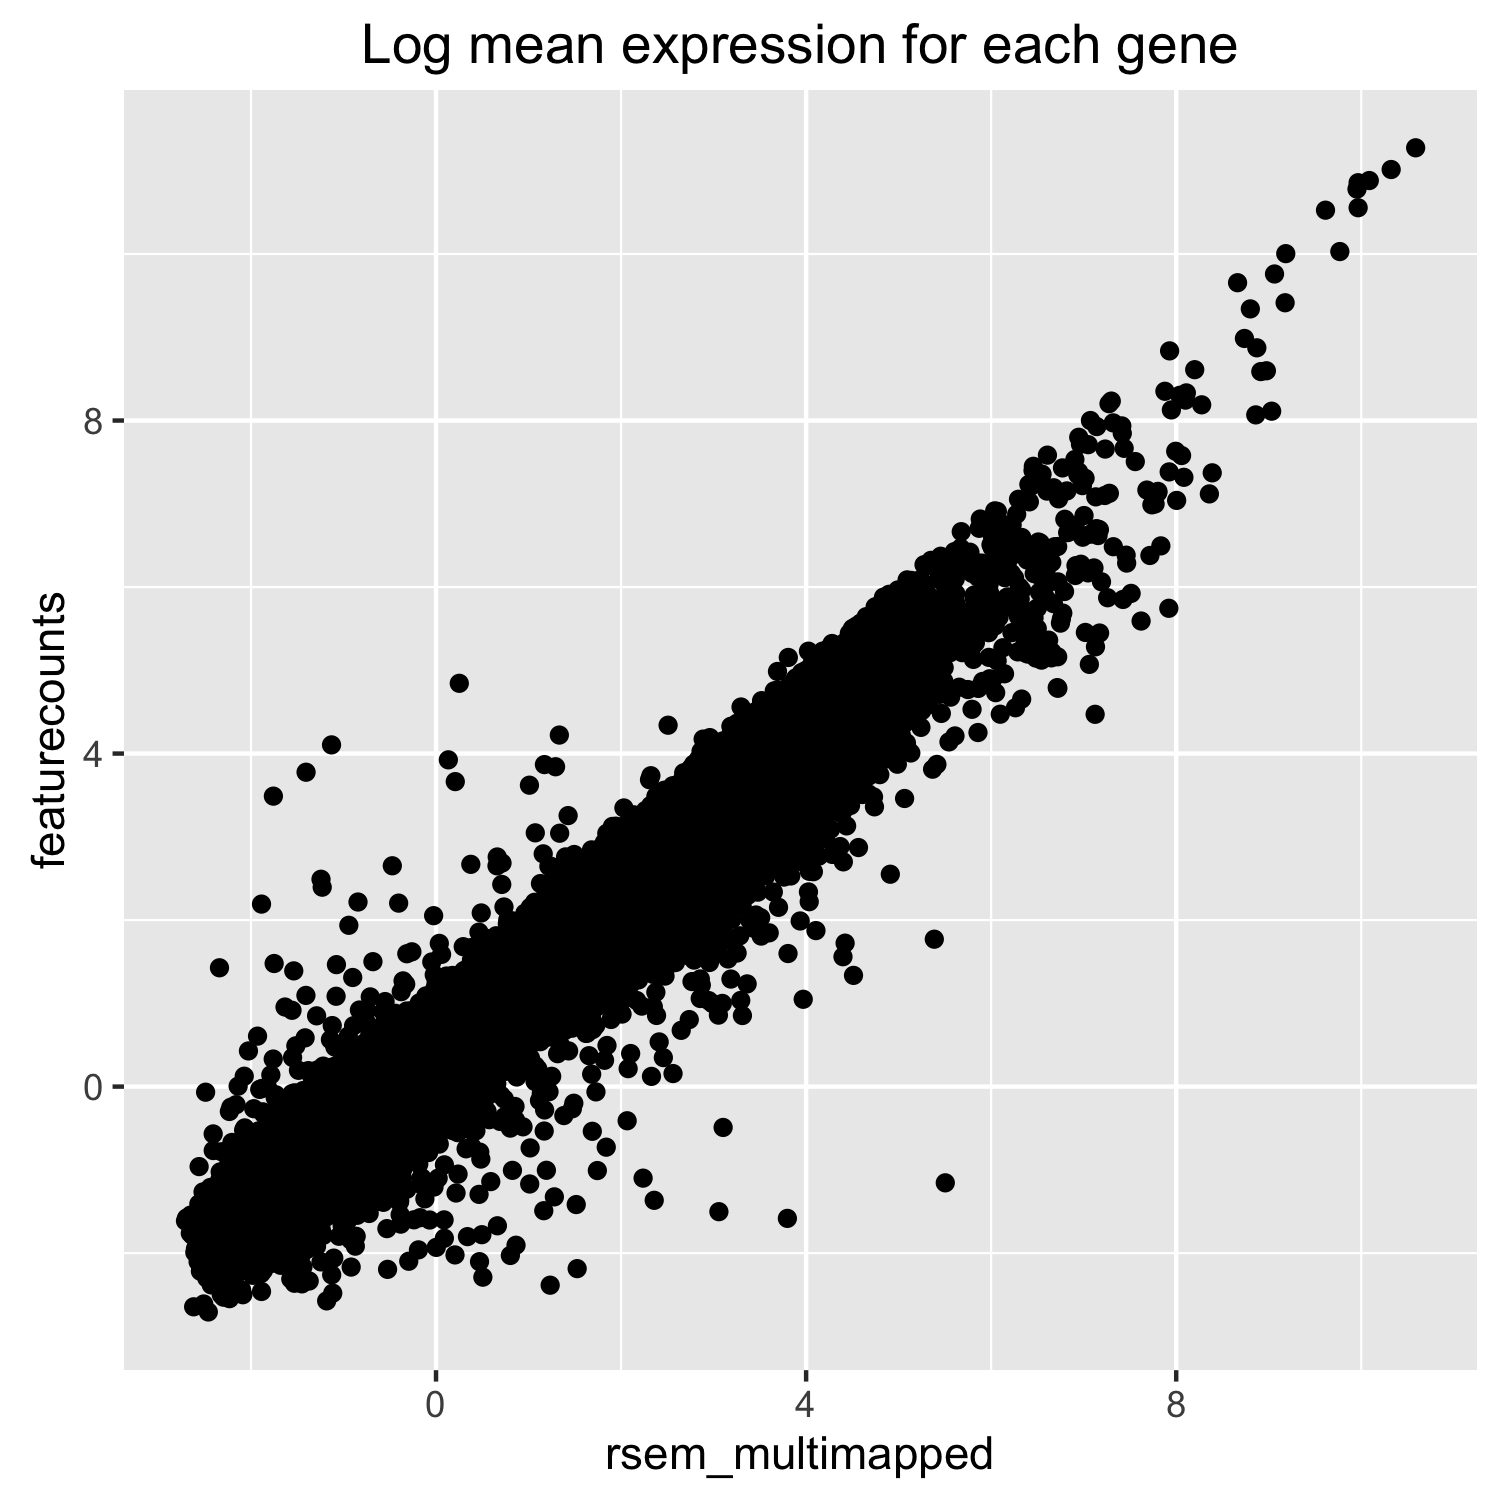

In [2]:
from IPython.display import Image
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/Genes_log_mean_expr_muscleskeletal_rsem_multimapped_featurecounts.png', width = 500) 

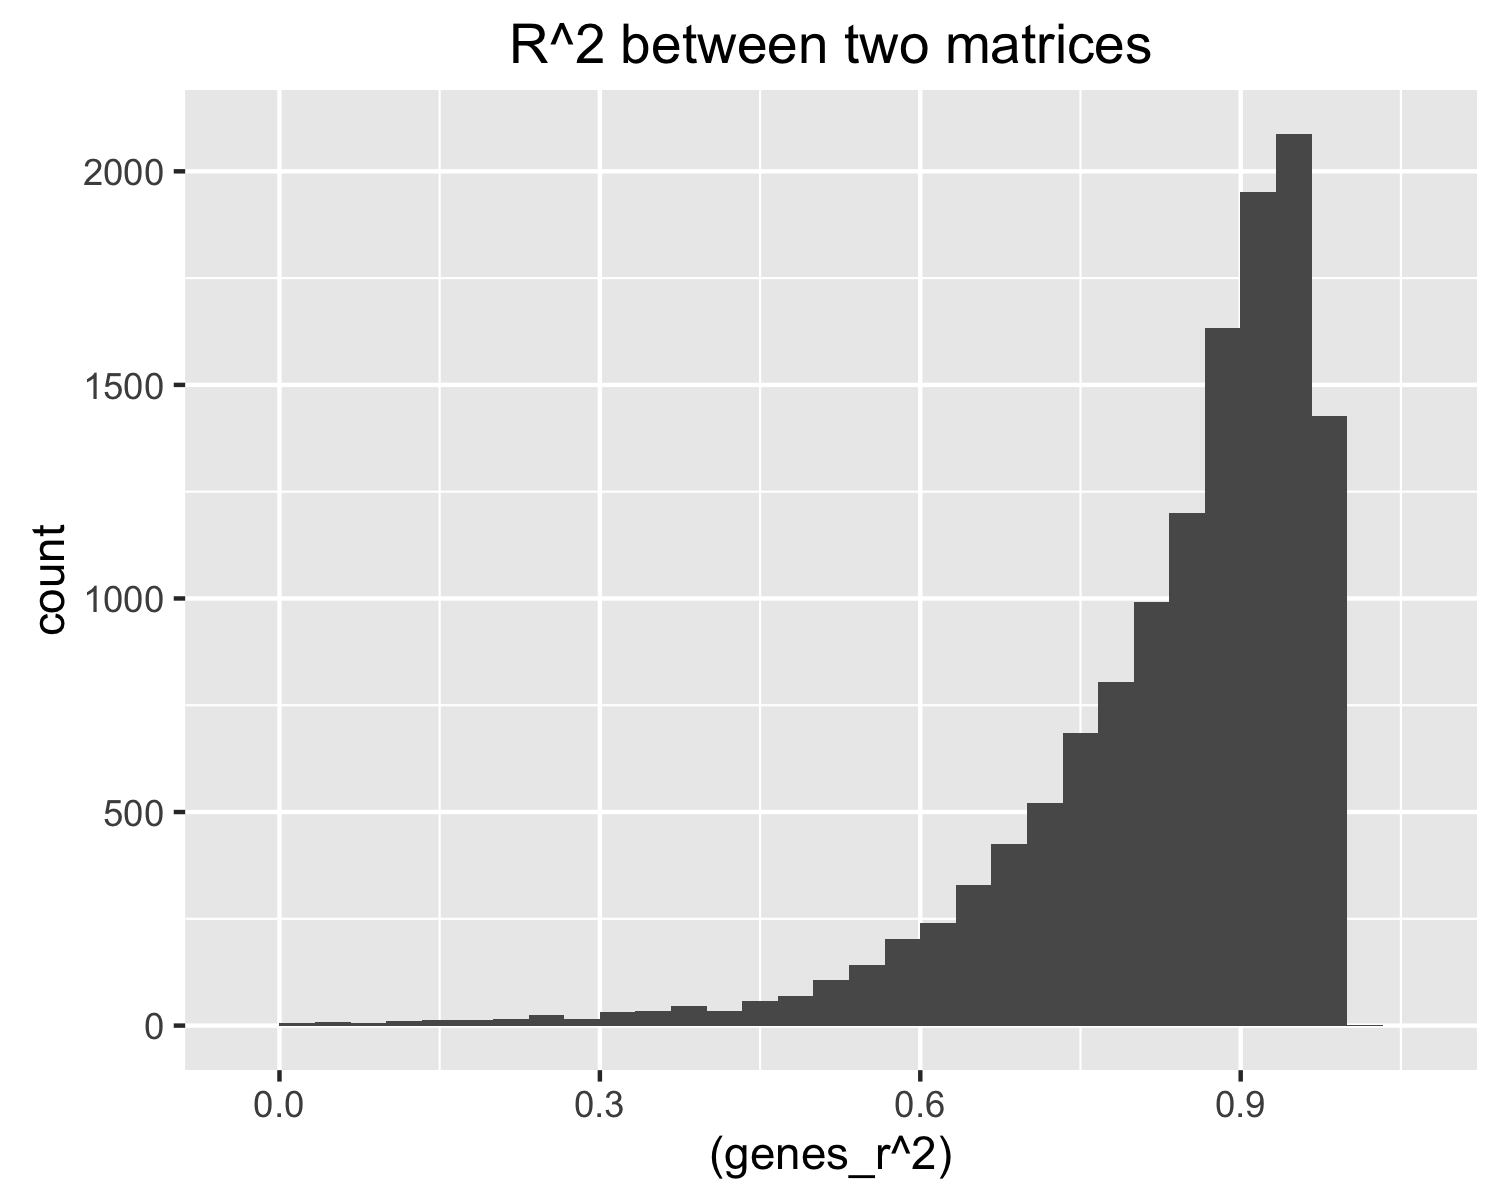

In [43]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/R_sq_muscleskeletal_rsem_multimapped_featurecounts.png', width = 400) 

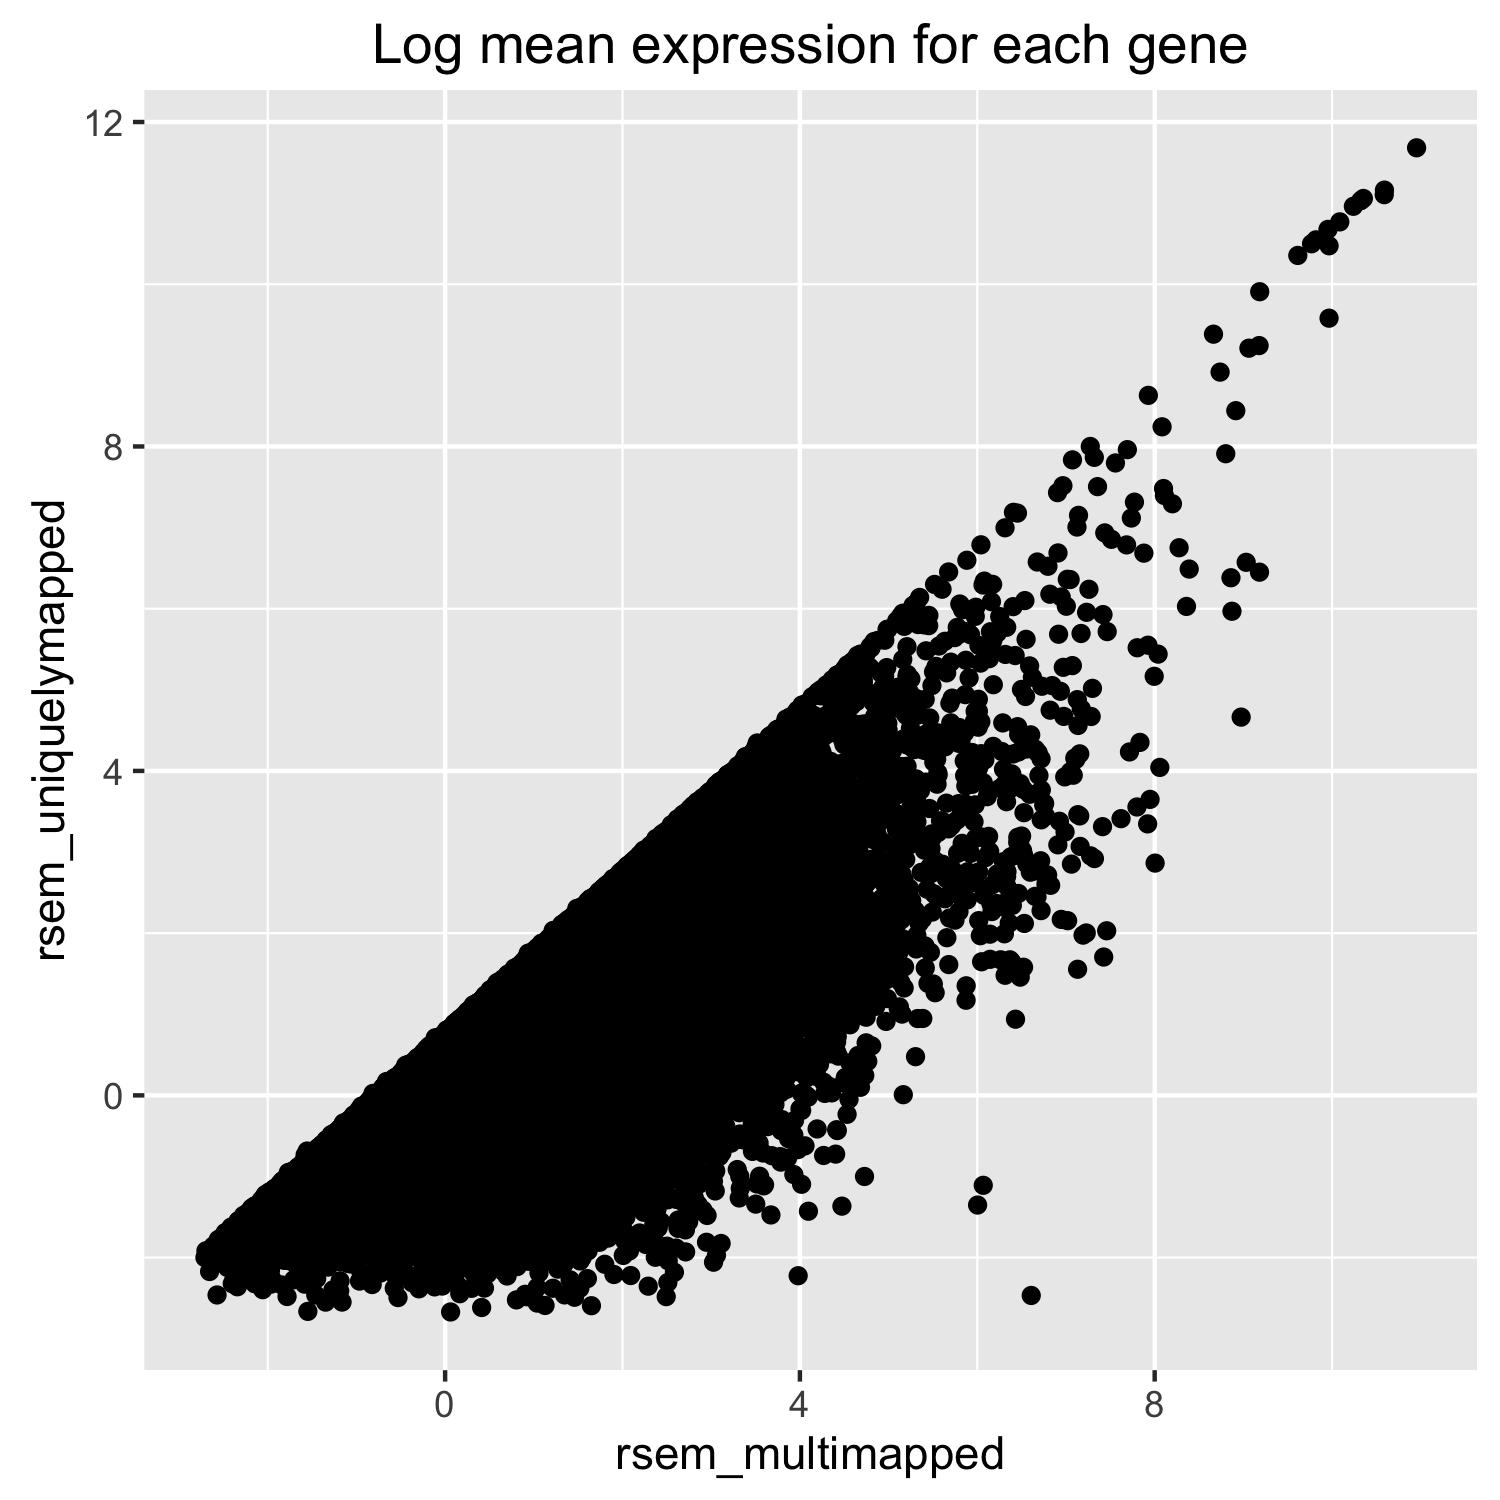

In [38]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/Genes_log_mean_expr_muscleskeletal_rsem_multimapped_rsem_uniquelymapped.png', width = 500) 

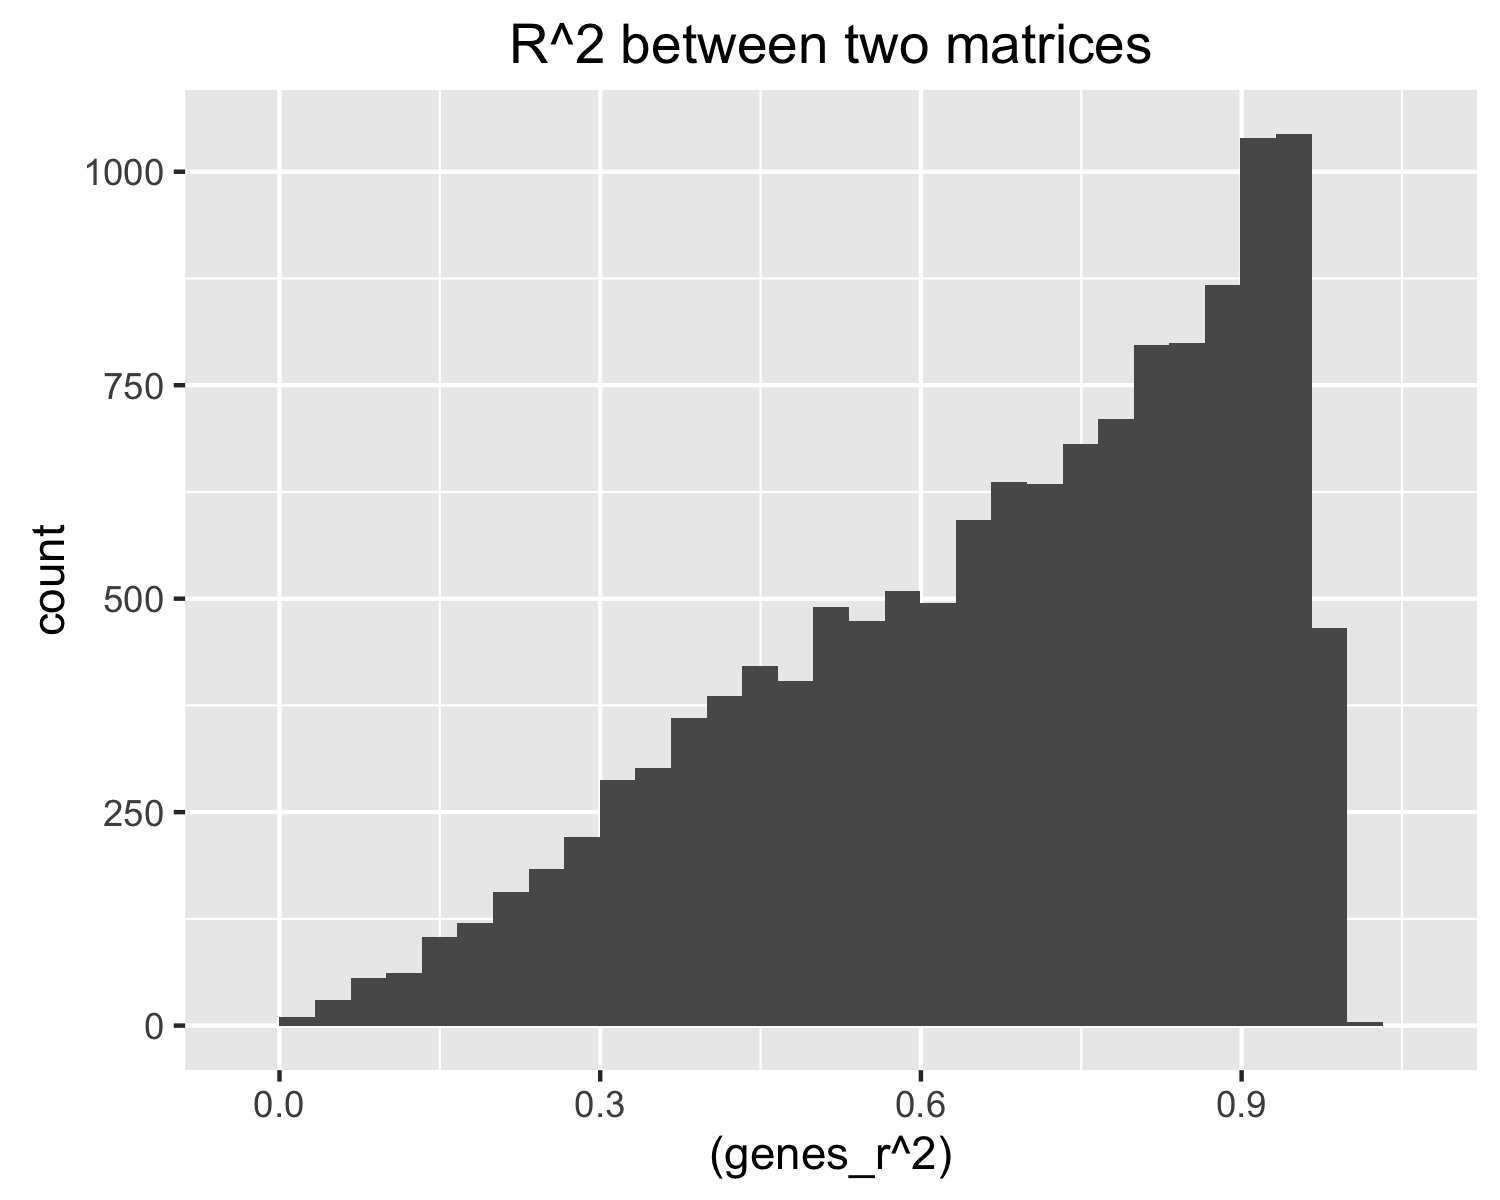

In [44]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/R_sq_muscleskeletal_rsem_multimapped_rsem_uniquelymapped.png', width = 400) 

It is notable that RSEM multi-mapping mode and featurecounts are more similar, although featurecounts doesn't take into account reads that map to multiple locations. As for RSEM uniquely-mapping, we can see a clear decrease in quantification due to the omission of multi-mapping reads.

- Whole Blood, comparison of RSEM (multi-mapping), RSEM (uniquely-mapping), and GTEx expression matrix:

In [ ]:
%%bash

Rscript /tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/expression_matrix_comparison.R \
wholeblood rsem_multimapped GTEx

Rscript /tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/expression_matrix_comparison.R \
wholeblood rsem_multimapped rsem_uniquelymapped

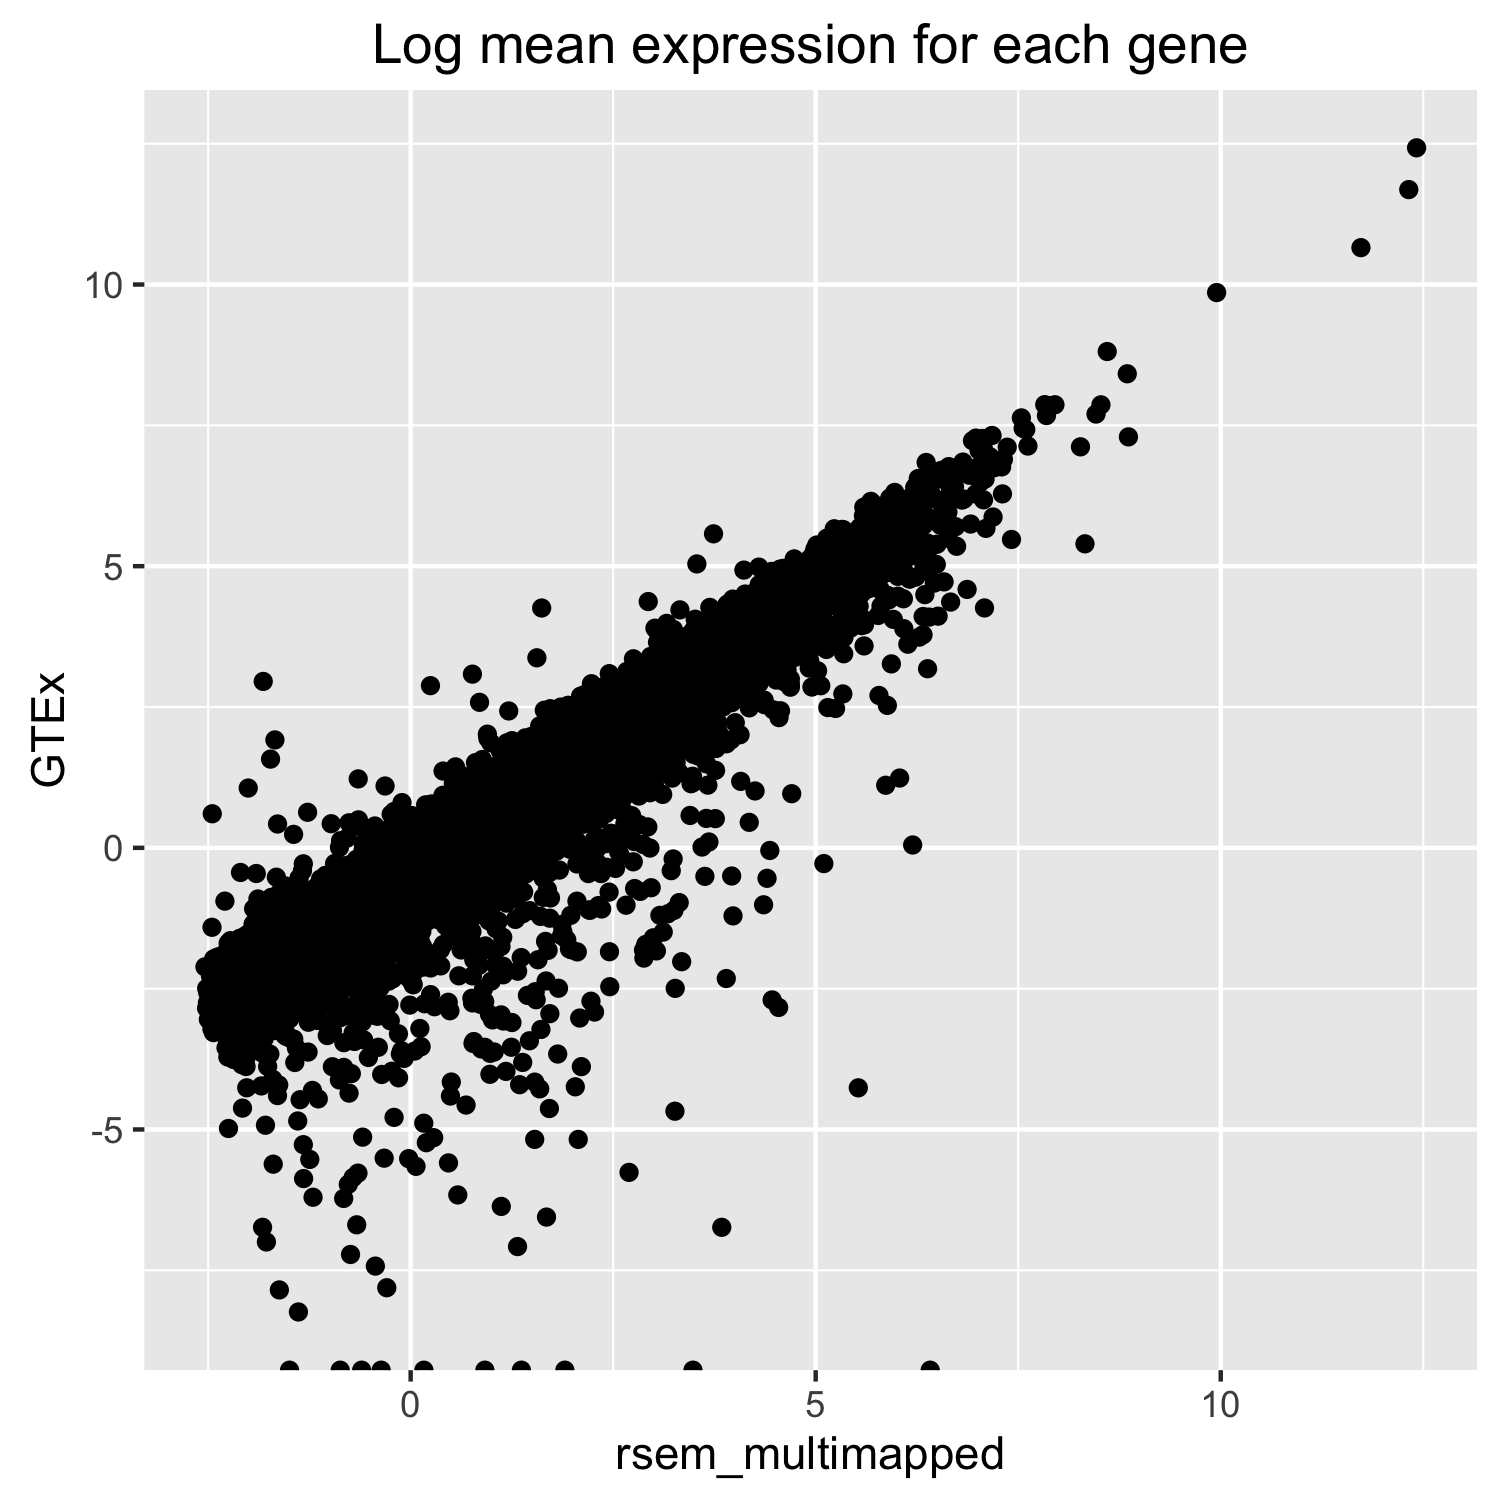

In [45]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/Genes_log_mean_expr_wholeblood_rsem_multimapped_GTEx.png', width = 500) 

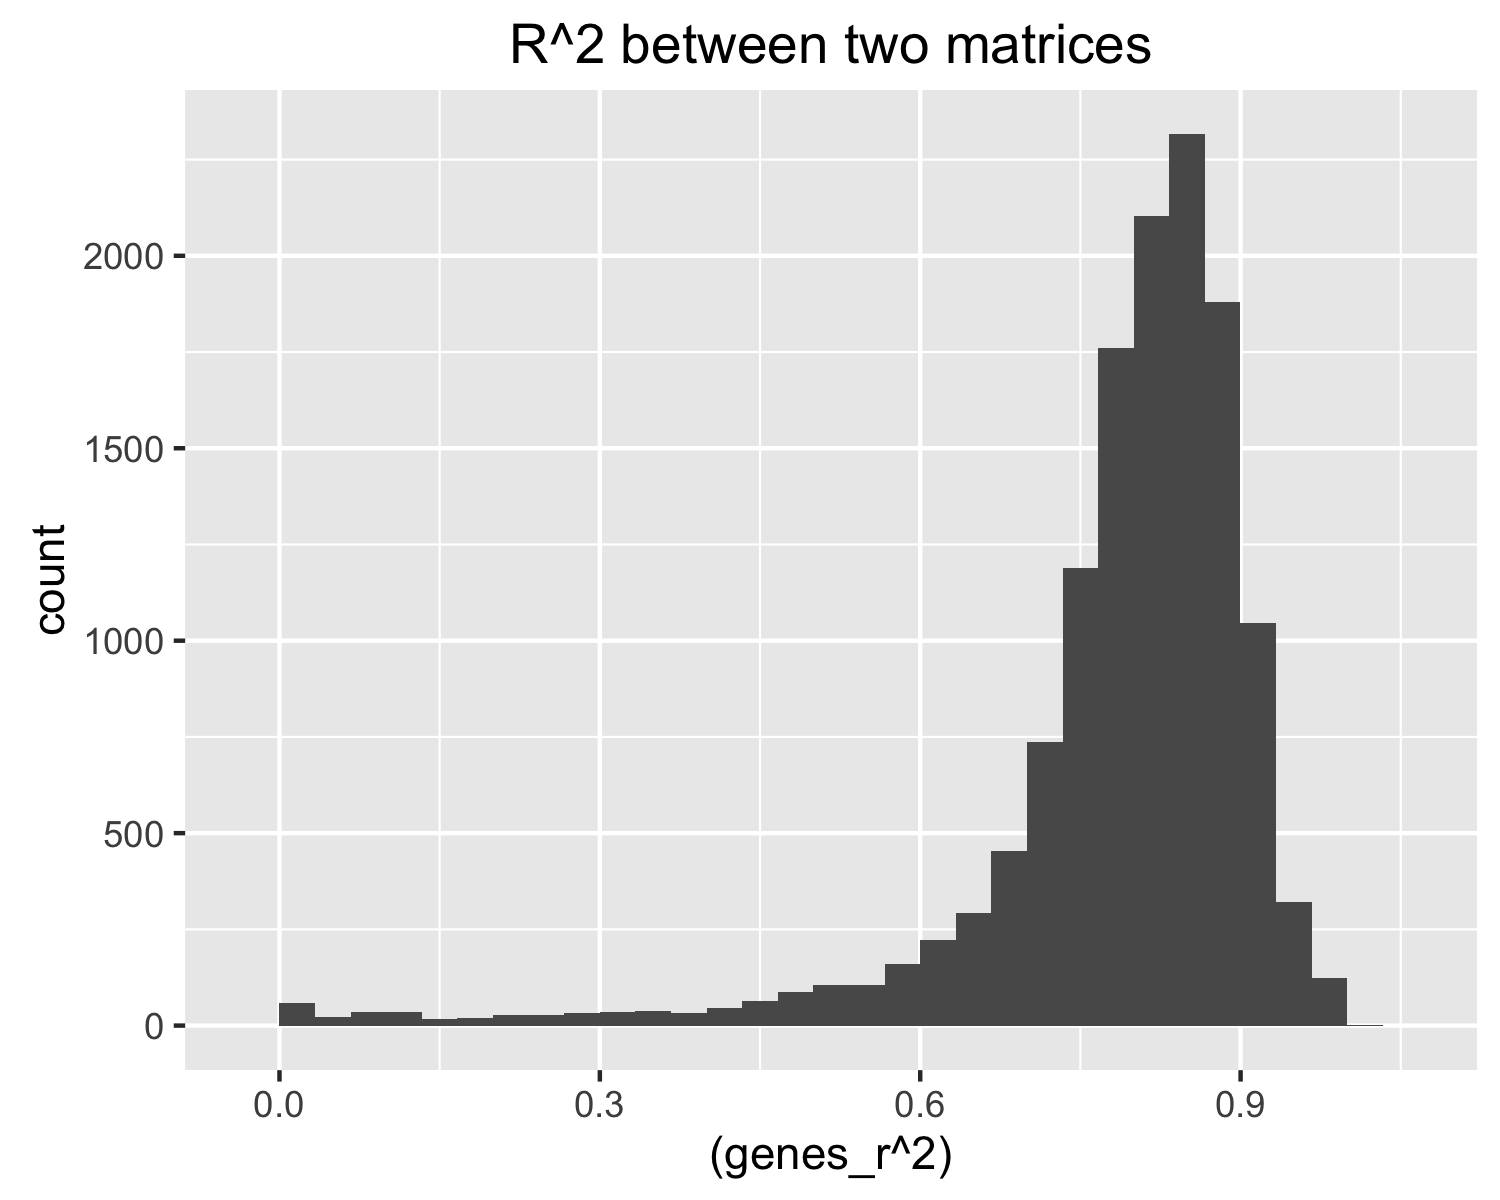

In [46]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/R_sq_wholeblood_rsem_multimapped_GTEx.png', width = 400) 

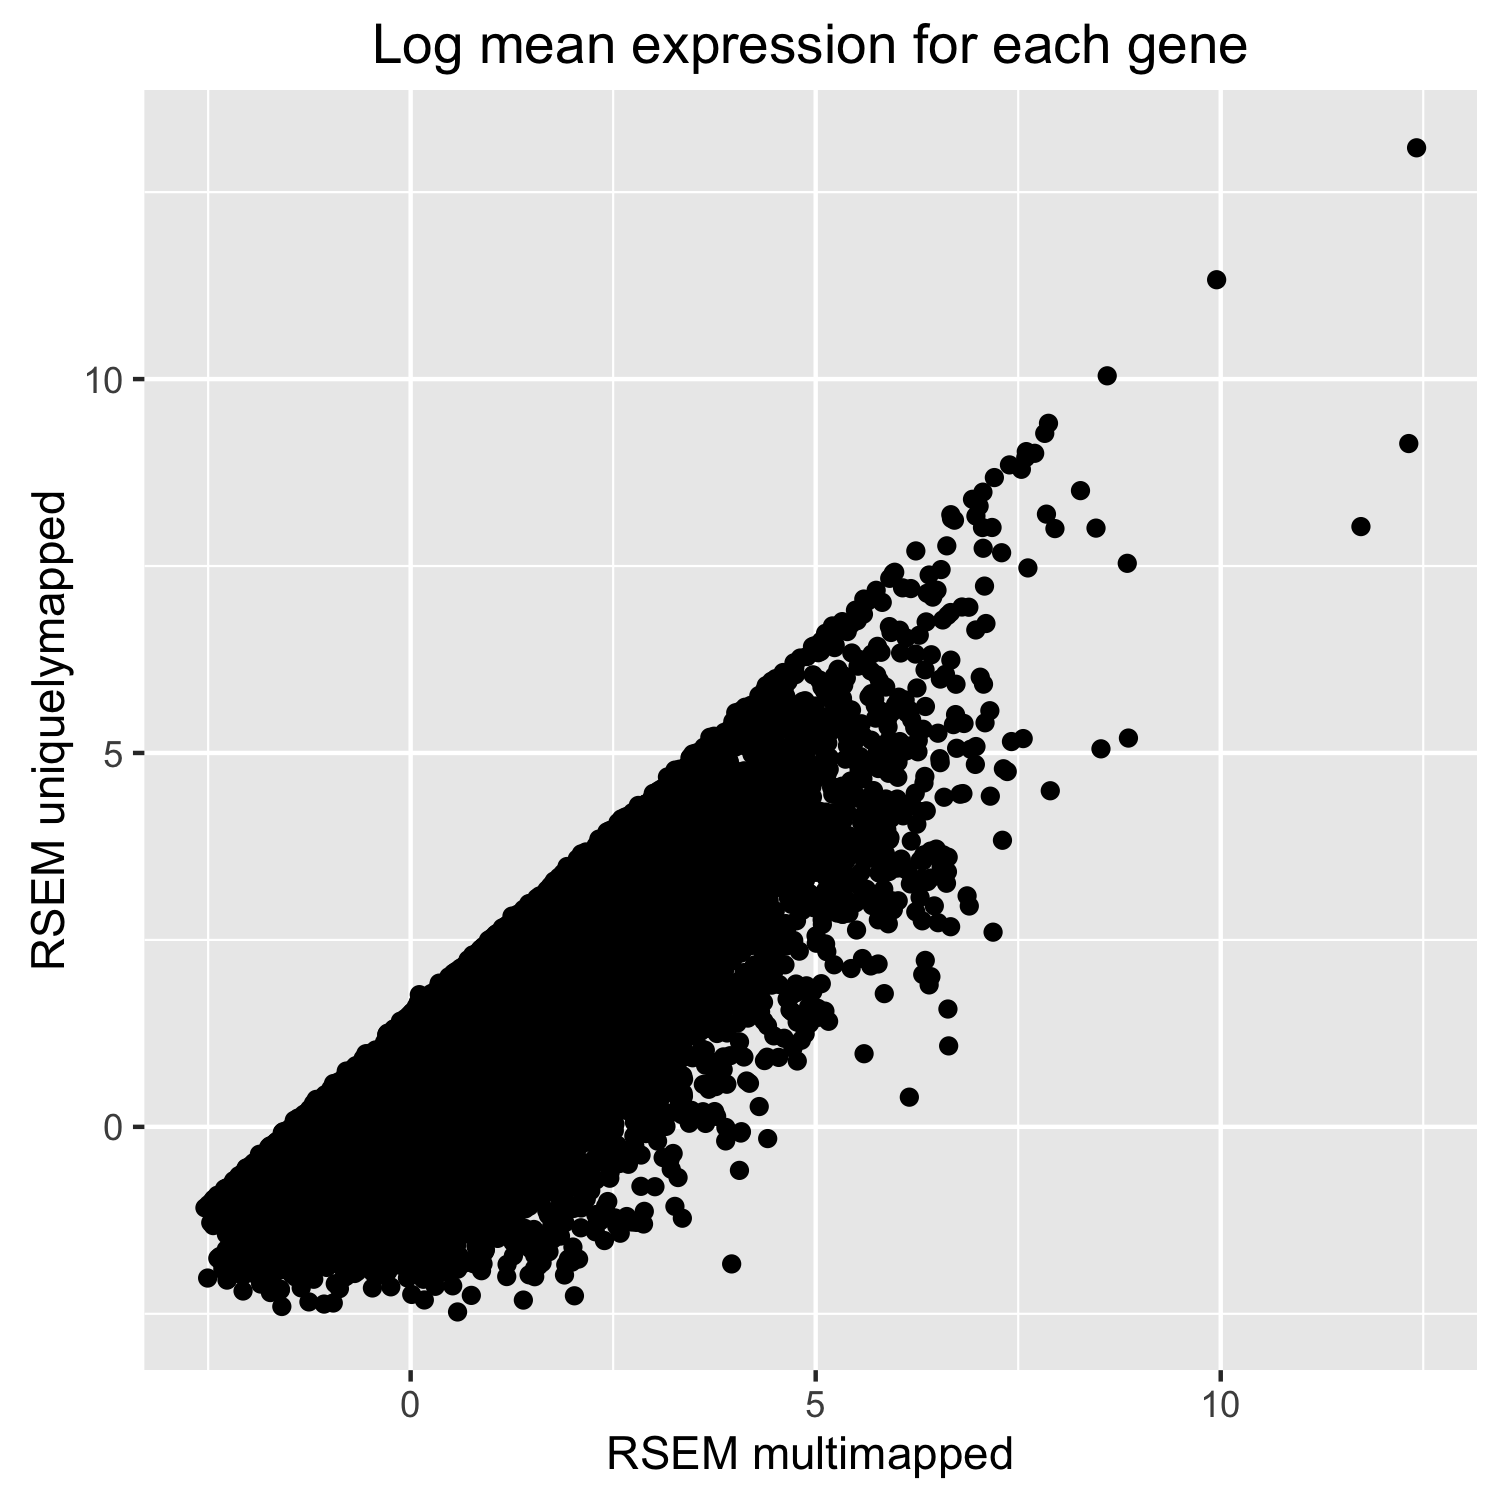

In [47]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/Genes_log_mean_expr_wholeblood_rsem_multimapped_rsem_uniquelymapped.png', width = 500) 

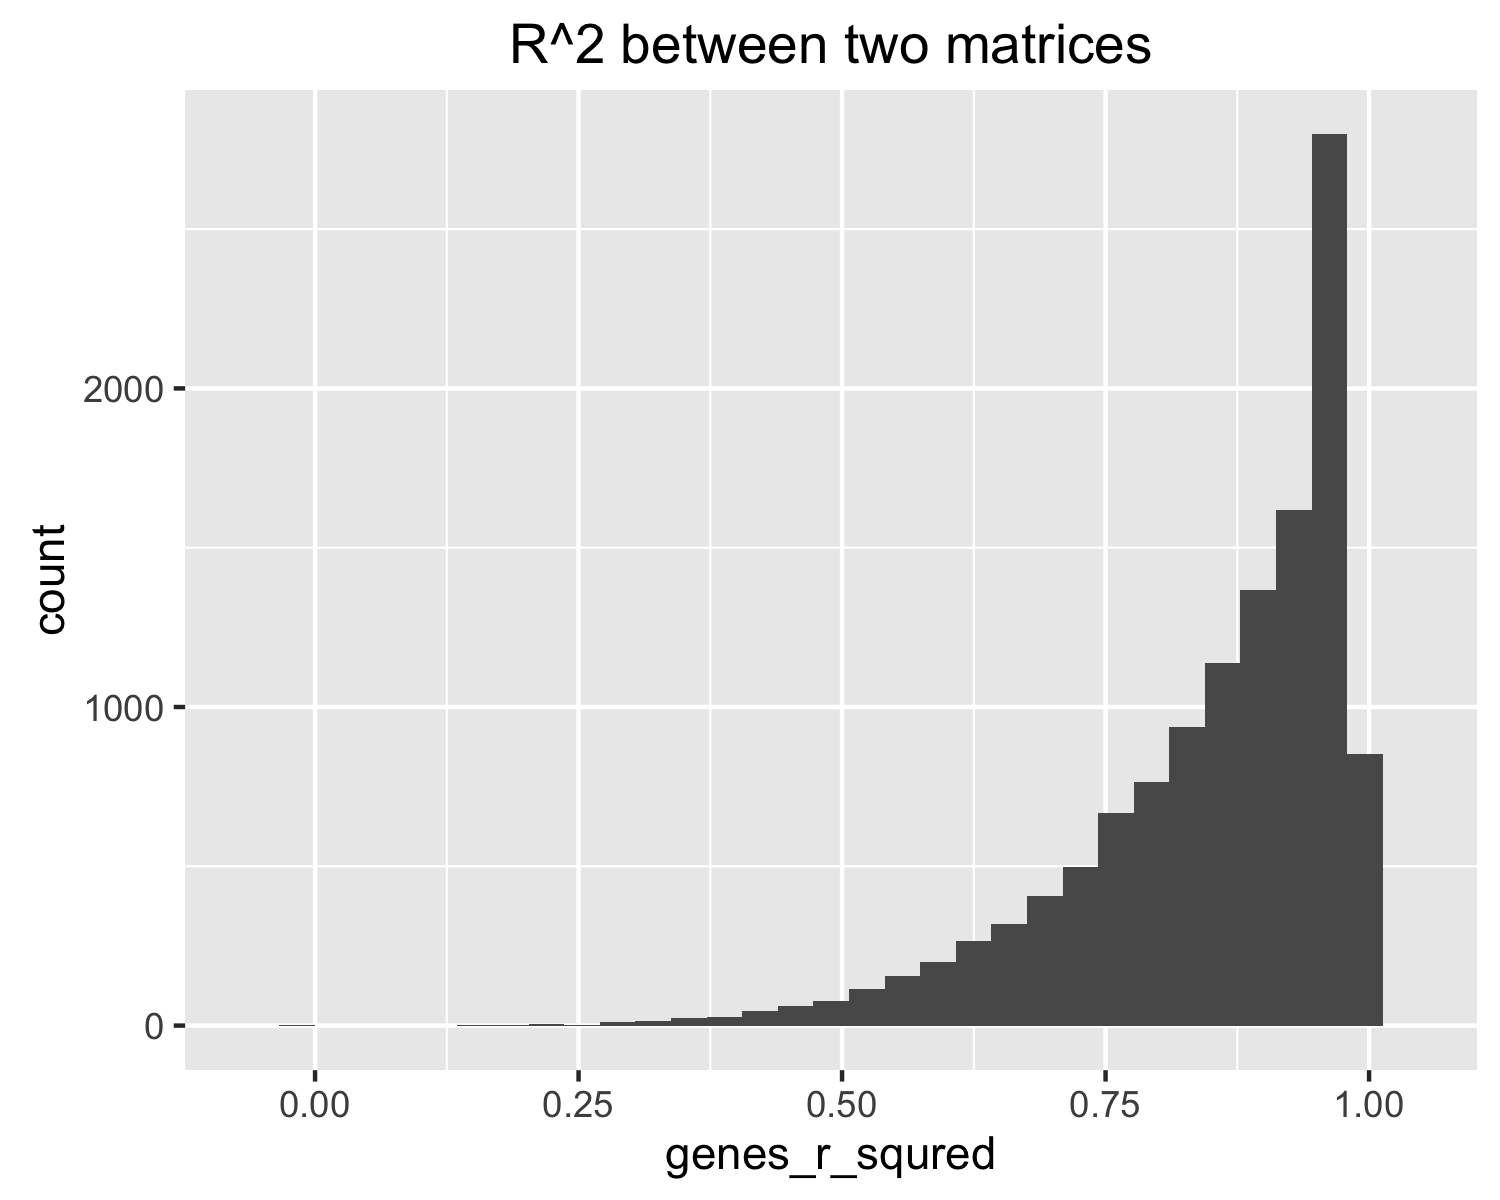

In [48]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/expression_matrix_comparison/R_sq_wholeblood_rsem_multimapped_rsem_uniquelymapped.png', width = 500) 

We can see that the GTEx consortium expression matrices are doing the equivalent of throwing away a lot of reads, as rather dramatically noted [here](https://liorpachter.wordpress.com/2013/10/21/gtex/)

## Relationship between inferred PEER factors and known covariates

Another interesting question we can ask of the data is whether the PEER factor optimization (as noted in the cis association notebook) is properly recovering the effects of known and unknown covariates. A simple way proxy would be to compare the inferred PEER factors to the known covariates in the data.

One thing to take note is that we need to provide the optimal PEER factor number. These optimal PEER factor numbers can be found in:

<code>/tigress/BEE/eQTLs/Data/References/GTEx/optimal_PEER</code>


In [ ]:
%%bash
Rscript /tigress/BEE/eQTLs/Analysis/Figures/PEER_known_cov_comparison/PEER_known_cov_comparison.R \
wholeblood rsem_multimapped 65

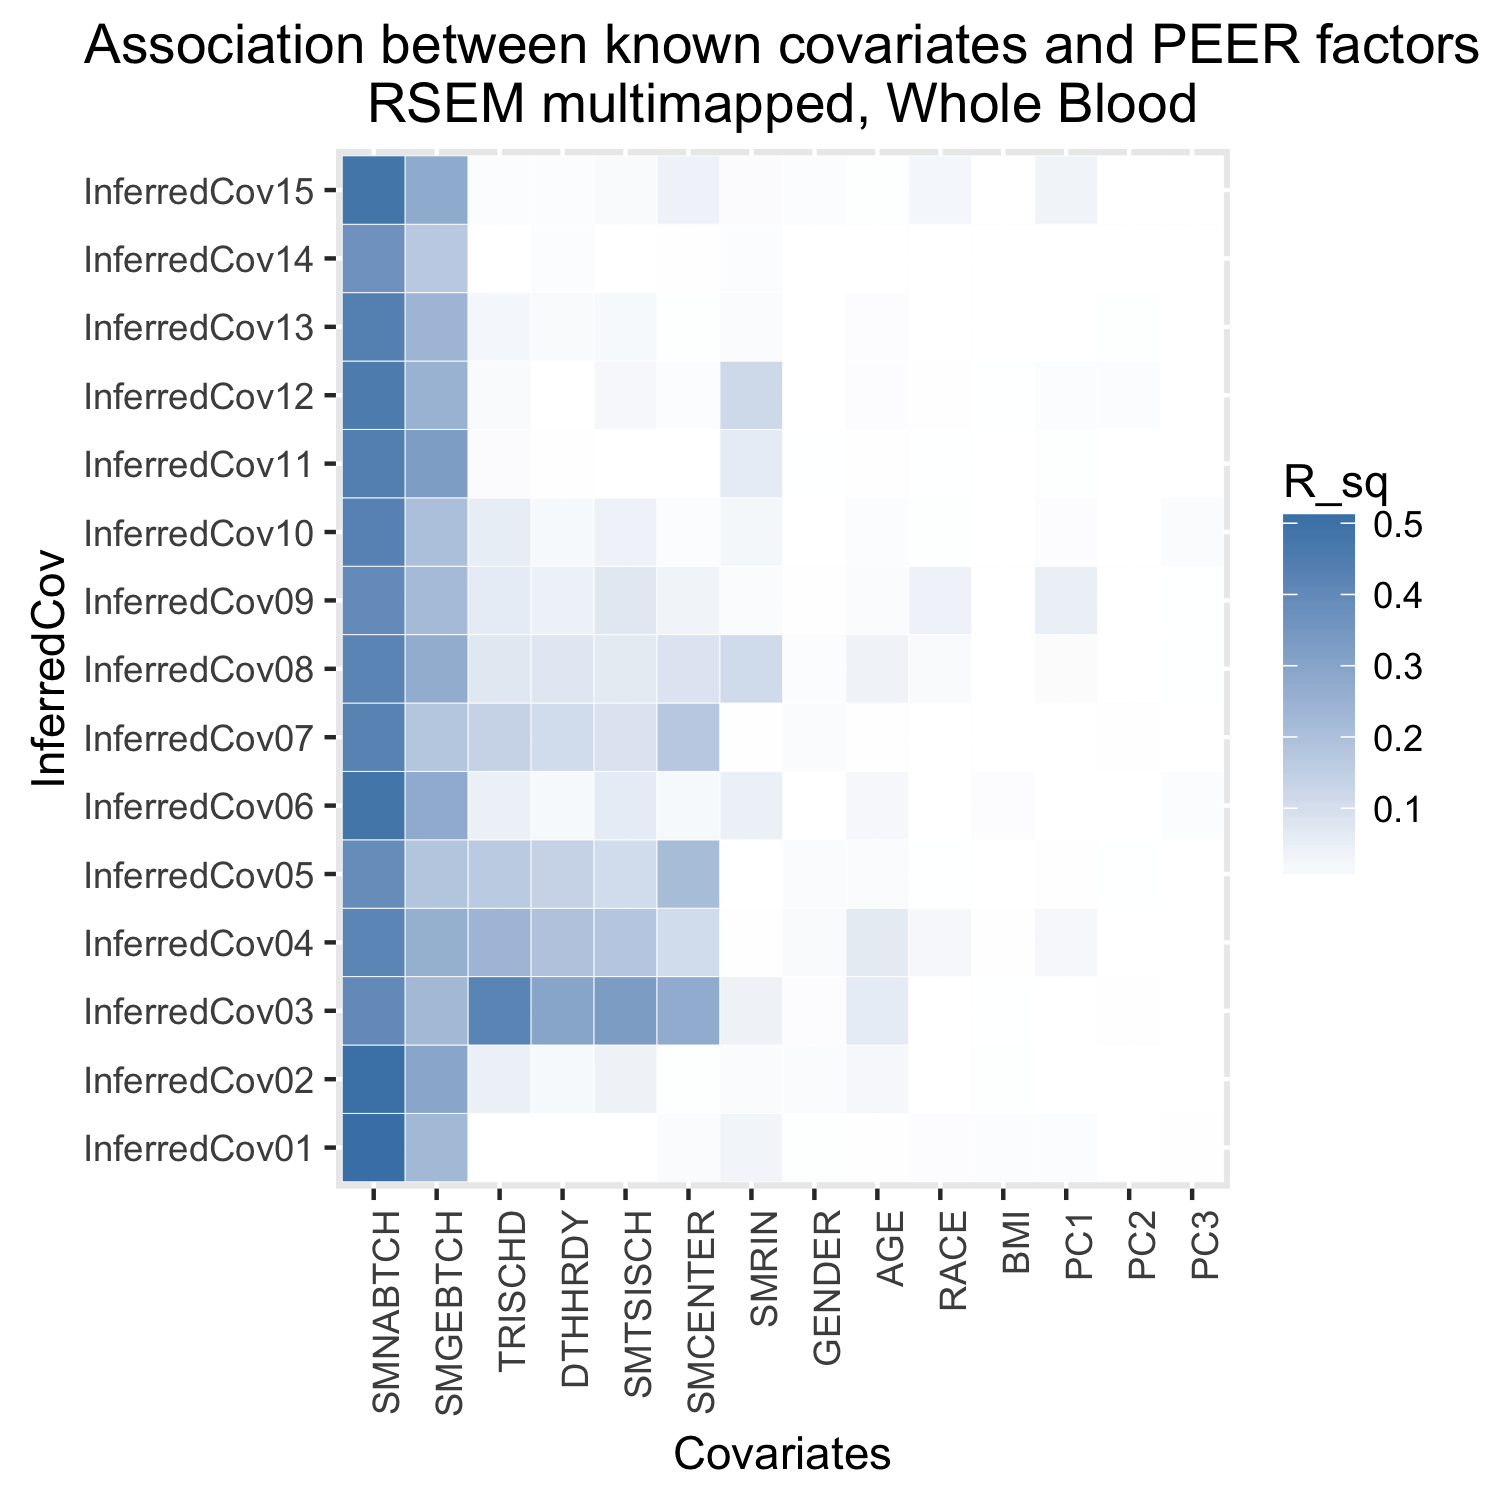

In [3]:
Image(filename='/tigress/BEE/eQTLs/Analysis/Figures/PEER_known_cov_comparison/wholeblood_rsem_multimapped_15.png', width = 500) 

## Quantified expression matrices vs. Multivariate normal assumption

How well does the multivariate normal assumption generalize in our quantified matrices? We calculate the Mahalanobis distance of each sample from the multivariate normal centroid, depending on the tissue and the quantification method.